# Data Assimilation: Importance Sampling
Femke Vossepoel F.C.Vossepoel@TUDelft.nl; 
Samantha Kim S.S.R.Kim@TUDelft.nl;
Dieter Werthmüller D.Werthmuller@TUDelft.nl

### Notebook structure  <a class="anchor" id="toc"></a>
- [Introduction](#intro)
- [Part I: Numerical model and observations (data)](#partI)
- [Part II: Importance Sampling](#partII)
- [Part III: Plots and analysis of the results](#partIII)


# Introduction  <a class="anchor" id="intro"></a>

In this practical, you will get to know the principle of importance sampling, which is the basis of the standard particle filter. Rather than using a _time-dependent_ filter, we will use a _static_ method, importance sampling. The distribution provided by the forward model is our prior, and the distribution of the difference between observation and model estimate is the likelihood. The product is proportional to the posterior.

In this case we use a forward model that represents the compaction of a subsurface layer (reservoir) as a result of a pressure drop in the reservoir. This pressure drop in the reservoir can be caused by, for example, the extraction of a fluid. The amount of compaction depends on the pressure difference, but also on the geomechanical parameter of the rock. Compaction in the deep subsurface leads eventually to subsidence at the surface. In this exercise we will estimate the geomechanical parameters of the reservoir by assimilating observations of the subsidence at the surface.

For this we consider the pressure, the compaction, and the surface deformation (subsidence) as the **state**. The geomechanical parameter is the **parameter**. In this exercise, we use importance sampling for parameter estimation, but it can also be used for state estimation, or joint parameter-state estimation.

<img src="pictures/compaction_scheme.png" width="500">

We will play with the number of parameters used to simulate the subsidence (the degrees of freedom of our system) and we will see how the parameter estimation changes with the number of particles. The results will help you to understand the concept of **ensemble degeneracy**.


## Objectives

1. Estimate the strength and the surface deformation with importance sampling.
2. Test the sensitivity to the setup of importance resampling, such as the ensemble size, the number of sources or the number of observations.

## Assignment

Assignment information are provided in blue boxes throughout the notebook, deliveries in red boxes. 

<div class="alert alert-info">
  
- Look at the code in each part and be sure you understand it all.
- Explain briefly what is set or computed in each part.

</div>

### Imports

In [20]:
import numpy as np                       # The numerical library we use
import matplotlib.pyplot as plt          # The plotting library we use
from mpl_toolkits.mplot3d import Axes3D  # For 3D-plots
from mogi_model import mogi              # Mogi source model

# Initiate a Random Number Generator
rng = np.random.default_rng()  # Preferred, "modern" way
# import numpy.random as rng   # Legacy way for NumPy < v1.17

# Uncomment the following line if you want interactive figures, e.g. rotating 3D figures.
#%matplotlib notebook

# Part I: Numerical model and observations (data) <a class="anchor" id="partI"></a> <small>[[TOC](#toc)]</small>

**It is important to note** that you could use this entire excercise with any other (geophysical) method. The only thing you have to change is

- **the forward model**, and accordingly 
- **the observations**.

We simply use the Mogi model together with subsidence data as an example on how to apply DA techniques.


<div class="alert alert-info">
      
Try to understand what "forward model" means; in general and in our particular case. Describe it in your own words.
    
</div>

## Forward model: Mogi

We try to predict our observed subsidence with a so-called "forward model": You assume an Earth model, you assume the physical relations, and you model the consequences of a change in one place at locations of interest. In this case we use the **Mogi** source model (Mogi, 1958). The Mogi source model simulates a depleting or inflating sphere in the subsurface. The model can be used for estimating subsidence, but also for estimating volume changes of a magma chamber. In the problem of reservoir compaction, we use one or several Mogi sources to represent a compacting reservoir (e.g., a producing gas reservoir, or an aquifer from which we extract water). Each Mogi source represents part of the compaction induced by the pressure drop.

We assume we know the depth of the Mogi sources from other information. Each Mogi source has a pre-defined strength and creates a deformation at the surface ($z=0$). **The strength of the Mogi source is proportional to the compaction coefficient $C_m$ (dimensionless).** It is the value of the parameter $C_m$ that we are after, but we model it through Mogi source strengths.

Using the forward model, we compute the surface deformation from the strength of the Mogi sources:

<h4><center>
    $C_m \rightarrow$ Forward Model Simulation $\rightarrow$ Surface deformation
    </center>
</h4>

The Mogi forward model is coded in the function `mogi()`, which can be found in the file `mogi_model.py`; we imported it already in the first cell. The signature of the function is `dx, dy, dz = mogi(x, y, z, sources, nu=0.25)` (the first four parameters must all be numpy arrays):

- `x`/`y`/`z` are arrays of the locations where you want to compute the subsidence, in [m].
- `sources` is a `3x4` array of source positions and strength `[[x1, y1, z1, strength1], ..., [xN, yN, zN, strengthN]]`; the coordinates are again in meters, the strength is a dimensionless factor, that is internally multiplied with a volume change of 1e6 m3.
- `nu` is the Poisson ratio; by default it is set to be 0.25.

**Note:** We simplify the problem here by only taking into account vertical displacement, and neglecting the horizontal displacement. A short way to achieve this is by calling the function like `dz = mogi()[2]`.

**Reference**: Mogi, K. (1958). Relations between the Eruptions of Various Volcanoes and the Deformations of 
the Ground Surface around them. Bulletin of the Earthquake Research Institute. Vol. 36. pp.99-134. 

### Let's see how Mogi works with some examples

#### (a) simple example

<div class="alert alert-info">
    
Play around with `mogi()`, change location and strength. How does it affect the predicted deformations?
    
</div>

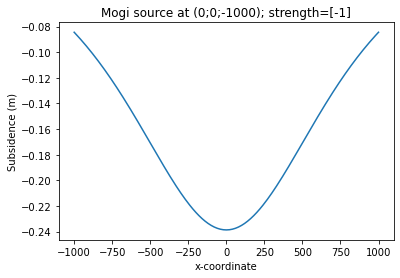

In [21]:
# Define observation points:
# One line from x=-1km to 1km, every 10 m; y=z=0
xcoo = np.arange(-1000., 1001., 10)#
ycoo = zcoo = xcoo*0

# Define source at x=y=0; z=-1km
source = np.array([0, -0, -1000])
# Strength -1 means that we compress the subsurface by 1e6 m3
strength = np.array([-1])

# Compute the subsidence.
pred_sub = mogi(xcoo, ycoo, zcoo, source, strength)[2]

fig, ax = plt.subplots()
ax.plot(xcoo, pred_sub)
ax.set_xlabel('x-coordinate')
ax.set_ylabel('Subsidence (m)')
ax.set_title(f'Mogi source at ({source[0]};{source[1]};{source[2]}); strength={strength}');

#### (b) advance example

`mogi()` allows to introduce several sources at a time, and we can also input an entire grid of coordinates and subsequently plot it in 3D as a surface.

<div class="alert alert-info">
      
Play around with `mogi()`:

  - different grids,
  - different amount of sources, strengths, etc.
    
How does it affect the predicted data?
 
</div>

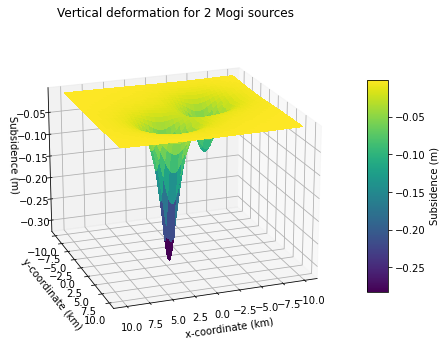

In [22]:
# Define observation points:
# Regular grid with x=y=-10km to 10km, every 100 m; z=0
xcoo = np.arange(-10000., 10001., 100)
ycoo = xcoo
Xcoo, Ycoo = np.meshgrid(xcoo, ycoo)
Zcoo = np.zeros_like(Xcoo)

# Define source sources at different locations.
# Strength is in Mogi multiplied with 1e6 m3.
# Positive strength means inflation, negative means compression.
sources = np.array([
    [ 2000,  2000, -1500],  # Source 1
    [-4000, -3000, -2000],  # Source 2
    # ... add/change sources!
])
# Corresponding strengths
strengths = np.array([-3, -2])
n_src = strengths.size

# Compute the subsidence.
pred_sub = mogi(Xcoo, Ycoo, Zcoo, sources, strengths)[2]

# Plot the surface subsidence in 3D.
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Xcoo/1e3, Ycoo/1e3, pred_sub, cmap='viridis', linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.65, aspect=10, label='Subsidence (m)')
ax.set_xlabel('x-coordinate (km)')
ax.set_ylabel('y-coordinate (km)')
ax.set_zlabel('Subsidence (m)')
ax.set_title(f'Vertical deformation for {n_src} Mogi sources')
ax.view_init(20, 70);

## Data

For the exercise we provide you with some subsidence data. Think of leveling data, GNSS or satellite data, such as InSAR data, that provide the information of the subsidence.

In the directory of the notebook there is a file called `subsidence_data`. This is a data file containing the measured subsidences at given observation points. Let's load the data and have a look at it.

<div class="alert alert-info">
  
Have a look at the data.
- Realize that we are limited by the finite amount of data.
- What can you tell from simply looking at the data and plotting it?
    
</div>

In [23]:
all_obs = np.loadtxt('subsidence_data.txt')
print("\n      = Observation locations and deformations  =\n\n"
      f"  # ::        x            y      z        subsidence\n{56*'-'}")
for i in range(all_obs.shape[0]):
    print(f"{i+1:3d} ::   {all_obs[i, 0]}    {all_obs[i, 1]}    {all_obs[i, 2]}    {all_obs[i, 3]:.6e}")


      = Observation locations and deformations  =

  # ::        x            y      z        subsidence
--------------------------------------------------------
  1 ::   730000.0    5920000.0    0.0    -6.522500e-02
  2 ::   730000.0    5910000.0    0.0    -6.202100e-02
  3 ::   730000.0    5900000.0    0.0    -7.464800e-02
  4 ::   740000.0    5920000.0    0.0    -5.748400e-02
  5 ::   740000.0    5910000.0    0.0    -1.319000e-01
  6 ::   740000.0    5900000.0    0.0    -4.065300e-02
  7 ::   750000.0    5920000.0    0.0    -3.544900e-02
  8 ::   750000.0    5910000.0    0.0    -9.323400e-02
  9 ::   750000.0    5900000.0    0.0    -4.368500e-02


So we can see that we have 9 measurements for a regular grid of 3x3 observation points at the surface.

**Note**: You can restrict your observations to test the workflow first on one observation, or on a few, in the following cell:

    # E.g.
    obs = all_obs[4, :]    # Takes only the 5th observation (Python has 0-indexing)
    obs = all_obs[::3, :]  # Takes every third observation

In [24]:
obs = all_obs[:, :]  # <= Restrict your observations here
n_obs = obs.shape[0]

In [25]:
def scatter(ax, data, title):
    im = ax.scatter(x=obs[:, 0]/1e3, y=obs[:, 1]/1e3, c=1e3*abs(data), s=1e4*abs(data), cmap='viridis')
    ax.set_xlabel('x-coordinate (km)')
    ax.set_ylabel('y-coordinate (km)')
    ax.set_title(title)
    ax.legend(
        title='Subsidence (mm)',
        *im.legend_elements("colors", num=8),
        loc=7, bbox_to_anchor=(1.4, 0.5),
        markerscale=2,
    )

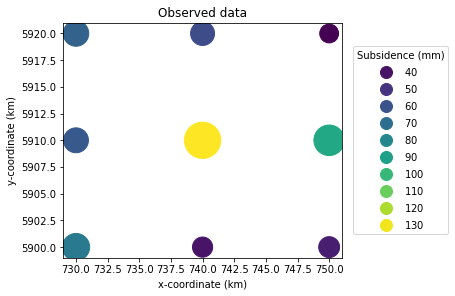

In [26]:
fig, ax = plt.subplots(constrained_layout=True)
scatter(ax, obs[:, 3], 'Observed data')

So even though we can forward model the response **at any point** we want, we often have only **a limited set of observations**.

In this case we have to make the most out of one observation each at nine distinct locations.

## Initial modelling of the observed data

We can use existing knowledge from geology, well logs, and other methods, to estimate some initial parameters and assumptions for our forward model `mogi()`:
- The compaction happens at a depth of roughly 3 km.
- We can assume a Mogi source at each observation (x/y).
- We start with a strength of -2 for each source.


<div class="alert alert-info">

- Define an appropriate grid to model the observed data.
- Model the observed data given above prior knowledge.
- Compare your modeled data with the observed data.
- Can you adjust the Mogi's strengths to predict the observed data?  
  (**Note**: you might want to start with just a single observation and a single source, and continue from there adding more and more observations/sources.)
    
</div>


<div class="alert alert-danger">
    
### Deliverable #1:

We start by assuming a source strength of `-2` for each Mogi source. Through manual try-and-error find your best assumption of the source `strengths` that fits the data.
  
</div>

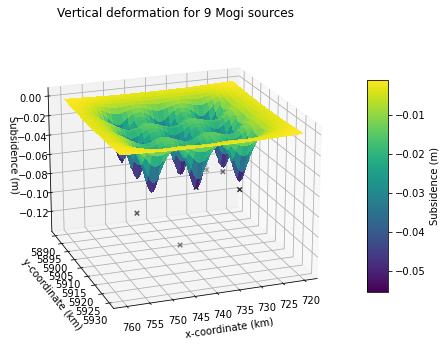

In [27]:
# Define observation points for 3D plot
xcoo = np.linspace(720000, 760000, 101)
ycoo = np.linspace(5890000, 5930000, 101)
Xcoo, Ycoo = np.meshgrid(xcoo, ycoo)
Zcoo = np.zeros_like(Xcoo)

# Define source sources at different locations.
# The strength-values decide how many sources.
# The maximum sources you can define is n_obs, as we use those coordinates.
# The minimum sources you should have is 1.
strengths = np.array([-2, -2, -2, -2, -2, -2, -2, -2, -2])  # 9 sources
# strengths = np.array([-2, ])                              # 1 source
n_src = strengths.size
sources = obs[:n_src, :3].copy()
sources[:, 2] = -3000  # Assumed source depths

# Compute the subsidence.
pred_sub = mogi(Xcoo, Ycoo, Zcoo, sources, strengths)[2]

# Plot the surface subsidence in 3D.
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Xcoo/1e3, Ycoo/1e3, pred_sub, cmap='viridis', linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.65, aspect=10, label='Subsidence (m)')

# Add observed data
ax.scatter(obs[:, 0]/1e3, obs[:, 1]/1e3, obs[:, 3], c='k', marker='x', zorder=100)

ax.set_xlabel('x-coordinate (km)')
ax.set_ylabel('y-coordinate (km)')
ax.set_zlabel('Subsidence (m)')
ax.set_title(f'Vertical deformation for {n_src} Mogi sources')
ax.view_init(20, 70);

(Note that observed data points (grey crosses) which are shallower than the coloured surface plot are hidden. This is a limitation of the matplotlib 3D plotting capabilities.)

Let's instead of computing the surface compute the values exactly at the observation points and print/plot the differences.


  # ::     observed     modelled   difference  strength
----------------------------------------------------------
  1 ::    -0.065225    -0.056701    -0.008524    -2
  2 ::    -0.062021    -0.058199    -0.003822    -2
  3 ::    -0.074648    -0.056701    -0.017947    -2
  4 ::    -0.057484    -0.058199     0.000715    -2
  5 ::    -0.131900    -0.059983    -0.071917    -2
  6 ::    -0.040653    -0.058199     0.017546    -2
  7 ::    -0.035449    -0.056701     0.021252    -2
  8 ::    -0.093234    -0.058199    -0.035035    -2
  9 ::    -0.043685    -0.056701     0.013016    -2


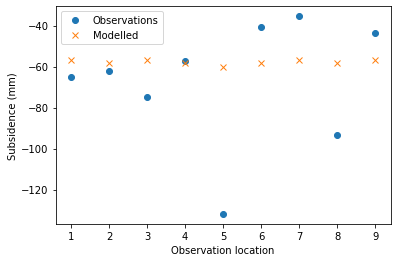

In [28]:
pred_obs = mogi(obs[:, 0], obs[:, 1], obs[:, 2], sources, strengths)[2]

print(f"\n  # ::     observed     modelled   difference  strength\n{58*'-'}")
for i in range(n_src):
    print(f"{i+1:3d} :: {obs[i, 3]:12.6f} {pred_obs[i]:12.6f} {obs[i, 3]-pred_obs[i]:12.6f}    {strengths[i]}")
    
fig, ax = plt.subplots()
ax.plot(np.arange(1, n_obs+1), obs[:, 3]*1e3, 'o', label='Observations')
ax.plot(np.arange(1, n_obs+1), pred_obs*1e3, 'x', label='Modelled')
ax.set_xlabel('Observation location')
ax.set_ylabel('Subsidence (mm)')
ax.legend();

<div class="alert alert-info">

Fill in your guess for the source strength estimates below

</div>

In [29]:
# TODO STUDENT PLEASE FILL IN  "best source strength estimates"
# strengths = np.array([xx, xx, xx, xx, xx, xx, xx, xx, xx])

# Part II: Importance Sampling algorithm  <a class="anchor" id="partII"></a> <small>[[TOC](#toc)]</small>

In the previous part we modelled observed data in a deterministic manner, assuming we "know" the location (x/y/z) of the source, and estimating a certain strength. As we have seen, the modelled data did not match our observations! This is because there are measurement errors, errors in our assumptions, and even errors in our forward model. (Note, the forward model is numerically correct, but it is based on a simplified assumption of the world, which also introduces errors.)

Looking at Bayes, we have to define first the **prior** using our model, and then our **likelihood** using the data. Given these two we can then estimate our **posterior**.

<img src="pictures/bayes.png" width="500">


## Step 1: Create the prior ensemble of our assumed strength


To account for these uncertainties we will now create a prior ensamble of our assumed strengths by creating a random distribution of it using, e.g., the normal distribution $\mathcal{N}$(mean, var). So our best guess of the `strengths` we found in the previous exercise becomes now the `prior_mean`, the mean of the prior source strength distribution. Creating such an ensemble accounts for many different uncertainties, e.g., actual location (x/y/z), actual strength, but also for uncertainties or simplifications we make in our forward model.
    
<div class="alert alert-info">

### (Optional) Standard deviation for Mogi-source stregnth
    
Create an ensemble of your assumed source strengths: Create random values of the strength from the distribution
    
$$\mathcal{N}(\bar{p}, \sigma_p)\, ,$$
    
where you use your assumed `strengths` as `prior_mean`. What is an appropriate value for the standard deviation? Write your answer here and calculate/plot the result below.
  
</div>

Note, in the first cell we initiated a random number generator `rng` with numpy. You can use this instance to create random numbers for various distributions, e.g., `rng.normal()`, `rng.uniform()`, and many more.

### First for a single source

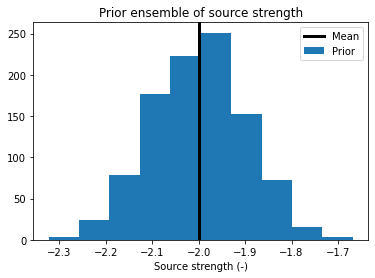

In [30]:
# Number of "particles" or realizations
n_part = 1000

# Let's pick the 4th source (Python starts with 0 index...)
# (i_src has to be smaller <= n_src)
i_src = 3

# We take the subsidence of our best prediction as the mean of our prior distribution
prior_mean = strengths[i_src]

# We start with a 5 % stddev
prior_rel_err = 0.05
prior_sigma = abs(prior_mean) * prior_rel_err

# Generate prior distribution with random realizations
prior_strengths = rng.normal(prior_mean, prior_sigma, n_part)

fig, ax = plt.subplots()
ax.hist(prior_strengths, label='Prior')
ax.axvline(prior_mean, c='k', lw=3, label='Mean')
ax.set_title('Prior ensemble of source strength')
ax.set_xlabel('Source strength (-)')
ax.legend();

### Now for all sources

In [31]:
# Normal distributed subsidences
prior_mean = strengths
prior_sigma = abs(prior_mean) * prior_rel_err
prior_strengths = rng.normal(loc=prior_mean[:, None], scale=prior_sigma[:, None], size=(n_src, n_part))

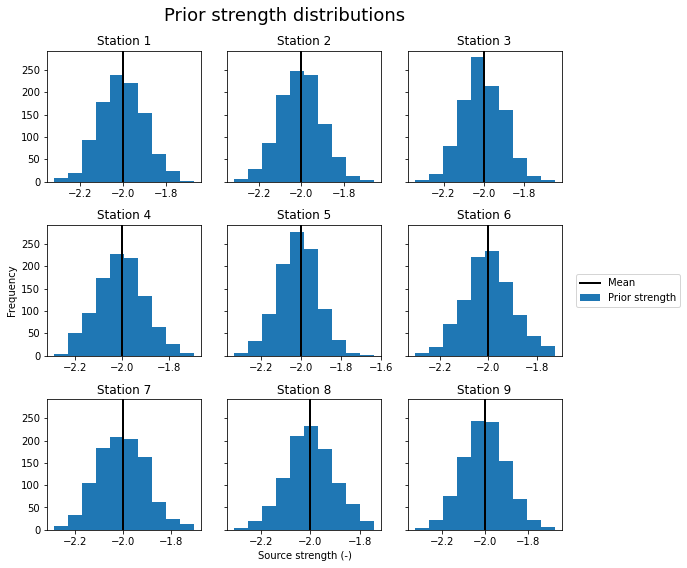

In [32]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharey=True)
rax = axs.ravel()
for i in range(n_obs):
    rax[i].set_title(f'Station {i+1}')
    rax[i].hist(prior_strengths[i, :], label='Prior strength')
    rax[i].axvline(strengths[i], c='k', lw=2, label='Mean')
axs[2, 1].set_xlabel('Source strength (-)')
axs[1, 0].set_ylabel('Frequency')
fig.suptitle('Prior strength distributions', fontsize=18)
fig.tight_layout()
lg = axs[1, 2].legend(loc='right', bbox_to_anchor=(1.8, 0.5))

## Step 2: Create the model prediction of deformation and innovation

Now we can calculate our prior distribution and consequently the squared innovation `innov2`, which is in this case the square of the difference between the observed data and our prior.

### Prior distribution

Using the ensamble of source strengths we can now compute the resulting predicted observations, our prior.

In [33]:
prior = np.zeros((n_obs, n_part))
for i in range(n_part):
    prior[:, i] = mogi(obs[:, 0], obs[:, 1], obs[:, 2], sources, prior_strengths[:, i])[2]

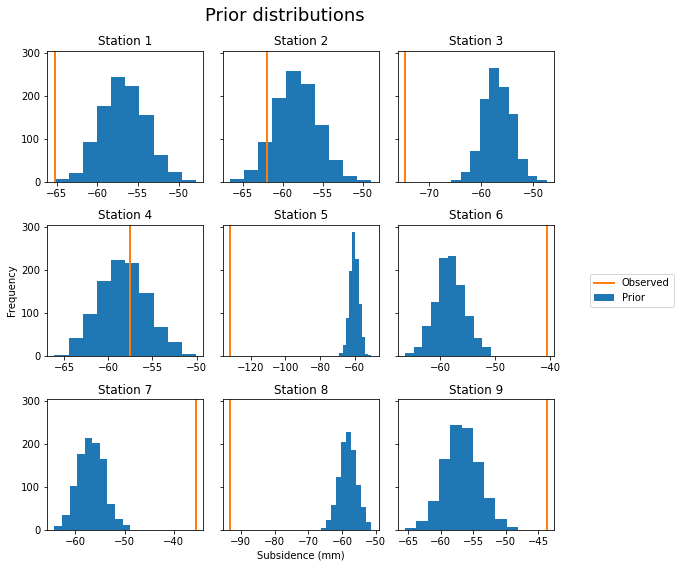

In [34]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharey=True)
rax = axs.ravel()
for i in range(n_obs):
    rax[i].set_title(f'Station {i+1}')
    rax[i].hist(prior[i, :]*1e3, label='Prior')
    rax[i].axvline(obs[i, 3]*1e3, c='C1', lw=2, label='Observed')
axs[2, 1].set_xlabel('Subsidence (mm)')
axs[1, 0].set_ylabel('Frequency')
fig.suptitle('Prior distributions', fontsize=18)
fig.tight_layout()
lg = axs[1, 2].legend(loc='right', bbox_to_anchor=(1.8, 0.5))

### Innovation squared: Squared differences between data and prior (model equivalent) for each particle

In [35]:
innov2 = (obs[:, 3][:, None] - prior)**2

## Step 3:  Calculate the likelihood and resulting weights

In [36]:
# Standard deviation of our likelihood
like_sigma = 0.005  # In [m]; so 5 mm

# Calculation of the likelihood
likelihood = 1 / ( 1 + ( innov2 / like_sigma**2 ) )

# Calculation of the weights
# The weights are the product of each `innov2` per particle
# - Shape innov2  : (n_obs, n_part)
# - Shape weights : (n_part, )
weights = np.prod(likelihood, axis=0)

# Normalize weights by total weight
weights /= np.sum(weights)

# Calculation of the weighted deformation
# The weighted deformation is the sum of prior * weights,
# which is equivalent to the dot product.
prior_weighted = np.dot(prior, weights)

# Part 3: Plots and analysis of the results <a class="anchor" id="partIII"></a> <small>[[TOC](#toc)]</small>

### Posterior subsidence distribution

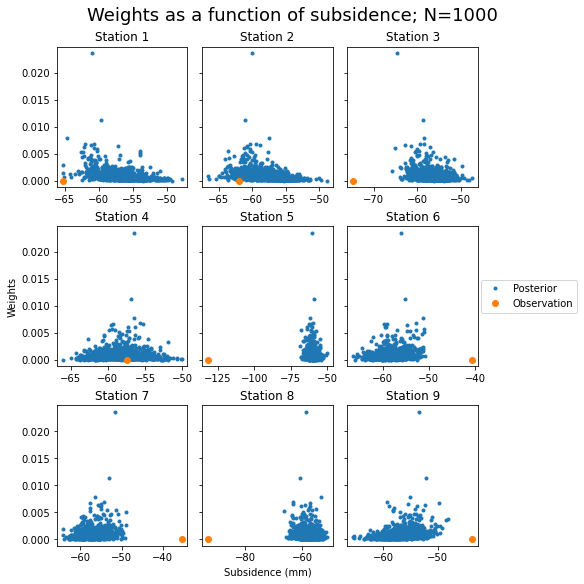

In [37]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharey=True, constrained_layout=True)
rax = axs.ravel()
for i in range(n_obs):
    rax[i].set_title(f'Station {i+1}')
    rax[i].plot(prior[i, :]*1e3, weights, 'C0.', label='Posterior')
    rax[i].plot(obs[i, 3]*1e3, 0, 'C1o', label='Observation')
axs[2, 1].set_xlabel('Subsidence (mm)')
axs[1, 0].set_ylabel('Weights')
fig.suptitle(f'Weights as a function of subsidence; N={n_part}', fontsize=18)
lg = axs[1, 2].legend(loc='right', bbox_to_anchor=(1.8, 0.5))

<div class="alert alert-info">

### (Optional) Posterior as a product of prior and likelihood

- Run the assimilation code for 1 Mogi source, keep `n_src==n_obs`. 
As you know, the posterior is the product of the prior distribution and the likelihood. 
Give your observations on the posterior distribution:
  - Does it look like a Gaussian distribution?
  - From what kind of distribution did we sample the likelihood? (see the array `dlpsi`)
  - Do you remember one of the advantages of using a particle filter over, for example, an Ensemble Kalman Filter?

</div>

<div class="alert alert-info">

### (Optional) Influence of prior on outcome of data assimilation

- Perform this synthetic experiment for different values of the prior strengths of the Mogi sources, keep `n_src==n_obs` constant. Observe and comment how the posterior distribution changes.

</div>

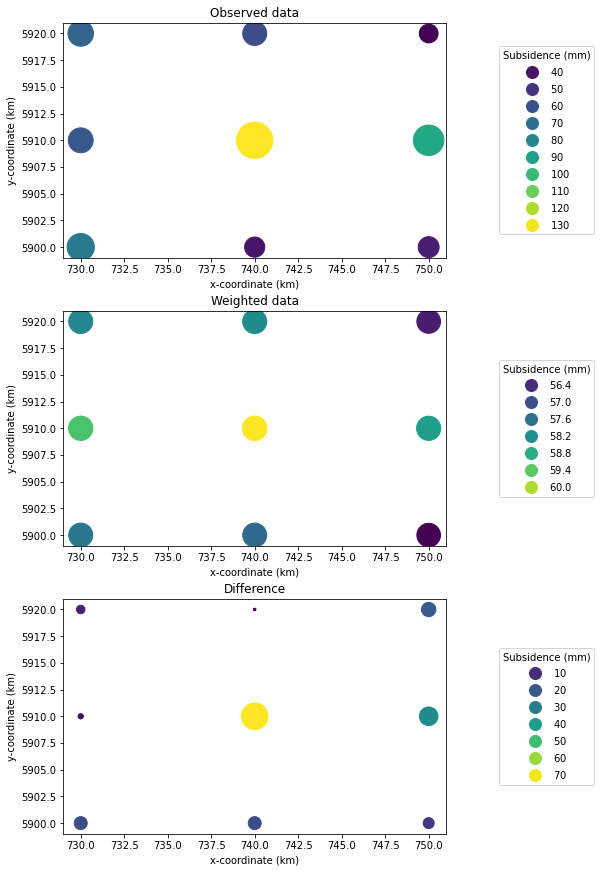

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12), constrained_layout=True)
scatter(ax1, obs[:, 3], 'Observed data')
scatter(ax2, prior_weighted, 'Weighted data')
scatter(ax3, obs[:, 3]-prior_weighted, 'Difference')

<div class="alert alert-danger">
    
### Deliverable #2: Effect of ensemble size

- Set any number of Mogi sources and any prior value of strength, keep `n_src==n_obs` constant. Test the effect of the ensemble size by changing the variable `n_part`. Observe and comment how the posterior distribution changes.

</div>

<div class="alert alert-danger">
    
### Deliverable #3: Under or overdetermined? Number of unknowns, number of observations, ensemble size

- Discuss how the number of Mogi sources and the ensemble size change the estimation of the strength and of the deformation.

- Set:
  - a number of Mogi sources `n_src==n_obs`  
  - a value for the ensemble size `n_part`.
  
Change the number of observation points by playing with the variable `n_obs`. Observe and comment if the posterior distribution changes.

</div>

<div class="alert alert-info">
    
### Wrapping up
    
- We have now estimated the surface deformation. Given this outcome, how would you estimate the posterior value of the strengths?

- Discuss how to get the best estimate of surface deformation and of strength. Remember that the objective of data assimilation is to estimate a parameter and its **probability density function**. This means that the the data-assimilation performs well if the posterior respects the uncertainties in prior and likelihood. 

- Given your results, what would be the main problem of importance sampling (standard particle filter)? What can we do to improve the fit to the truth? 
    
</div>